In [1]:
#%matplotlib qt

## imports
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import matplotlib
from matplotlib import cm
import h5py
import os
from math import pi, sqrt
from scipy.optimize import curve_fit
import scipy
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import time
from scipy.interpolate import InterpolatedUnivariateSpline
rc('text', usetex=True)
import seaborn as sns
from os import path

# Plot parameters
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3


## Read and plot GW data

In [2]:
## Data reading functions

def GetWaveformRadius(p, rad):
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5'
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[rad]
    coord_radius = f[radius]['CoordRadius.dat'][0][1]
    return coord_radius
    
def GetPsi4Mode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rPsi4_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainMode(p, mode, radius=-1): 
    ## which finite radius should we use?
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'GW2/rh_FiniteRadii_CodeUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    radius = sorted(f.keys())[radius]
    data = f[radius]['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetPsi4ModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    psi4_file = p + 'rMPsi4_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(psi4_file, 'r')
    data = f['Extrapolated_N' + str(order) +'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    Psi4 = re + 1j*im
    return time, Psi4

def GetStrainModeExtrapolated(p, mode, order=2): 
    l = mode[0]
    m = mode[1]
    h_file = p + 'rhOverM_Asymptotic_GeometricUnits.h5' 
    f = h5py.File(h_file, 'r')
    data = f['Extrapolated_N'+str(order)+'.dir']['Y_l' + str(l) + '_m'  + str(m) + '.dat']
    time, re, im = data[:,0], data[:,1], data[:,2]
    h = re + 1j*im
    return time, h

In [3]:
## Data helper functions

def CutTimes(time, data, TLow, TUp): ###
    TLowIndex = np.where(time >= TLow)[0][0]
    TUpIndex = np.where(time <= TUp)[0][-1]
    time = time[TLowIndex:TUpIndex]
    data = data[TLowIndex:TUpIndex]
    return time, data

def GetPeakTimeMode(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.absolute(data))]
    return t_peak

def GetPeakTimeModeReal(time, data): ###
    ## Peak time being the peak of the magnitude of the data
    t_peak = time[np.argmax(np.real(data))]
    return t_peak

def SubtractPeakTimeMode(time, data): ###
    t_peak = GetPeakTimeMode(time, data)
    return time - t_peak

def SubtractPeakTimeModeReal(time, data): ###
    t_peak = GetPeakTimeModeReal(time, data)
    return time - t_peak

def InterpolateTimes(time, data, time_dest):
    """ Interpolates time, data onto new time axis
        time_dest """
    interpolant = scipy.interpolate.CubicSpline(time, data)
    return interpolant(time_dest)

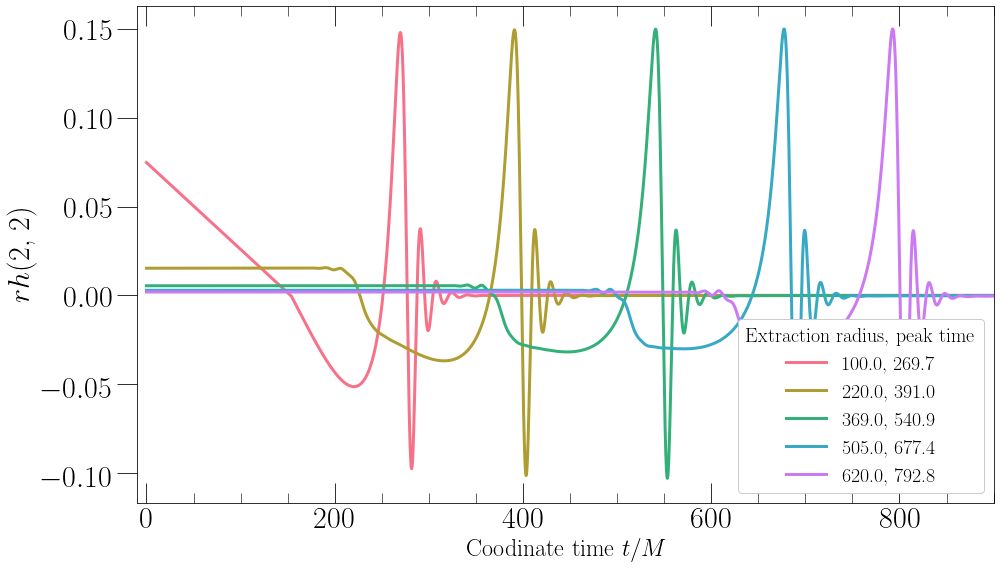

In [6]:
## Plot strain at various radii

def PlotRadiiStrain(p):
    ## Run Progress
    plt.figure(figsize=(14, 8))

    mode = (2,2)
    
    radii = [0, 15, 20, 22, 23]
    cs = sns.color_palette('husl', n_colors=len(radii))

    for rad, i in zip(radii, range(len(radii))):

        radius = int(GetWaveformRadius(p, rad))
        
        time, data = GetStrainMode(p, mode, radius=rad)
        tt = GetPeakTimeMode(time, data)
        
        plt.plot(time, np.real(data), label='%.1f, %.1f' % (radius, tt), color=cs[i])

    plt.xlabel(r'Coodinate time $t/M$')
    plt.ylabel(r'$rh$' + str(mode), fontsize=30)
    legend = plt.legend(loc='lower right', title='Extraction radius, peak time', fontsize=20, framealpha=1.0)
    plt.setp(legend.get_title(),fontsize=20)
    plt.xlim(-10, 900)
    plt.tight_layout()
    plt.savefig('RadiiPeaks.pdf')
    plt.show()
    
#PlotRadiiStrain('Data/HeadOn/JoinedLev1/')
PlotRadiiStrain('Data/HeadOn_Harmonic/JoinedLev2/')

## Plot lensing refinement method results + final positions

In [ ]:
## Plot the vanilla SpEC lensing run results

def PlotRefinementMethodResult(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""
    
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_positions = data[:,1]
    y_positions = data[:,2]
    z_positions = data[:,3]
    
    plt.figure(figsize=(10, 10))
    
    plt.scatter(y_positions, z_positions, color='red', s=10)
    #plt.xlim(-5.0, 5.0)
    #plt.ylim(-5.0, 5.0)

    plt.xlabel(r'Camera X')
    plt.ylabel(r'Camera Y')
    plt.tight_layout()
    plt.savefig('Camera.pdf')
    plt.show()
    
PlotRefinementMethodResult('Data/Kerr')

In [ ]:
## Plot the vanilla SpEC lensing run results

def Plot3DFinalPositions(p):
    
    """ Print the results of the vanilla lensing run. For the file structure, we have
    Geo's final time,
    Geo's final position x,
    Geo's final position y,
    Geo's final position z,
    Geo's final 4-momentum t (roughly, redshift),
    Geo's final 4-momentum x,
    Geo's final 4-momentum y,
    Geo's final 4-momentum z"""

    plt.rcParams['grid.linewidth'] = 0.25
    
    file = p + '/RefinementMethodData.h5'
    f = h5py.File(file, 'r')
    data = f['GeodesicFinalVars.dat']
    
    x_pos = data[:,1]
    y_pos = data[:,2]
    z_pos = data[:,3]
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
    
    ax.scatter(x_pos, y_pos, z_pos, color='red', s=10)
    ax.scatter([0.0], [0.0], [100.0], color='black', s = 100)
    ax.quiver([0.0], [0.0], [100.0], [0.0], [0.0], [-10.0], length=20.0, normalize=True, color='black')
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    plt.tight_layout()
    plt.savefig('Positions.pdf')
    plt.show()
    
Plot3DFinalPositions('Data/Kerr')


## Read in horizon data and create interpolants
## Read in geodesic trajectories

In [2]:
## Read in horizon trajectories

Lev = "2"

def read_horizon_trajectories(Horizon):
    """ Horizon is a string corresponding to the BH we're interested in [A, B, C]"""
    f = "Data/HeadOn_Harmonic/JoinedLev" + Lev + "/ApparentHorizons/Trajectory_Ah" + Horizon + ".dat"
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

## Build the horizon interpolants
t_a, x_a, y_a, z_a = read_horizon_trajectories("A")
spl_x_a = InterpolatedUnivariateSpline(t_a, x_a)
spl_y_a = InterpolatedUnivariateSpline(t_a, y_a)
spl_z_a = InterpolatedUnivariateSpline(t_a, z_a)

t_b, x_b, y_b, z_b = read_horizon_trajectories("B")
spl_x_b = InterpolatedUnivariateSpline(t_b, x_b)
spl_y_b = InterpolatedUnivariateSpline(t_b, y_b)
spl_z_b = InterpolatedUnivariateSpline(t_b, z_b)

t_c, x_c, y_c, z_c = read_horizon_trajectories("C")
t_merger = t_b[-1]
t_ringdown = t_c[0]
spl_x_c = InterpolatedUnivariateSpline(t_c, x_c)
spl_y_c = InterpolatedUnivariateSpline(t_c, y_c)
spl_z_c = InterpolatedUnivariateSpline(t_c, z_c)

def horizon_at_time(time, Horizon):
    if Horizon == "A":
        return spl_x_a(time), spl_y_a(time), spl_z_a(time)
    if Horizon == "B":
        return spl_x_b(time), spl_y_b(time), spl_z_b(time)
    if Horizon == "C":
        return spl_x_c(time), spl_y_c(time), spl_z_c(time)
    else:
        print("Unrecognized horizon argument")

def min_distance_to_horizon(t, x, y, z):
    """ Returns the minimum distance of a geodesic to a horizon over all time
        t, x, y, z are arrays with the history of the geodesic"""
    min_distance = 1e10
    
    def distance_sqr(xx, yy, zz, xx_h, yy_h, zz_h):
        return (xx - xx_h)**2 + (yy - yy_h)**2 + (zz - zz_h)**2
    
    def distance_to_horizon(time, xx, yy, zz):
        """ Returns the minimum distance to the relevant horizon at given time"""
        min_dist = 1e10
        ## look at AhA and AhB before merger
        if time <= t_merger:
            for horizon in ["A", "B"]:
                xx_h, yy_h, zz_h = horizon_at_time(time, horizon)
                dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
                min_dist = min(min_dist, dist)
        ## look at AhC after ringdown
        elif time > t_ringdown:
            xx_h, yy_h, zz_h = horizon_at_time(time, "C")
            dist = distance_sqr(xx, yy, zz, xx_h, xx_h, xx_h)
            min_dist = min(min_dist, dist)
        return min_dist
                
    ## minimize over the times
    for time, xx, yy, zz in zip(t, x, y, z):
        
        dist_horizon = distance_to_horizon(time, xx, yy, zz)
        min_distance = min(min_distance, dist_horizon)
        #print(time, min_distance)
        
    return(sqrt(min_distance))
            

In [4]:
## Functions for reading geodesic positions over time from NodeX.h5 files

def read_geodesic_data(p):
    """ Read in an array of times and positions for all geodesics at once"""
        
    file = p + '/Node0.h5'
    f = h5py.File(file, 'r')
    ## grab the .dat files
    keys = [k for k in f.keys() if 'dat' in k]
    ## Array of times from the .dat files
    times = [float(k.split('.dat')[0]) for k in keys]
    ## sort keys according to times
    times, keys = zip(*sorted(zip(times, keys)))
    times = times[::-1]
    keys = keys[::-1]
    ## grab the number of geodesics
    N_geodesics = len(f[keys[0]][:,0])
    print("Total geodesics: ", N_geodesics, "Time steps: ", len(times))
    ## Minimum index
    m = int(f[keys[0]][:,0][0])
    print("Minimum index of this refinement iteration: ", m)
    
    X = [ [] for _ in range(N_geodesics)]
    Y = [ [] for _ in range(N_geodesics)]
    Z = [ [] for _ in range(N_geodesics)]
    T = [ [] for _ in range(N_geodesics)]
    
    for k, t in zip(keys, times):
        data = f[k]
        ## indices and positions for all geodesics at this time
        indices = data[:,0]
        x = data[:,5]
        y = data[:,6]
        z = data[:,7]
        ## fill in the array for each index
        for i, j in zip(indices.astype(int), range(len(indices))):
            X[i-1-m] = np.append(X[i-1-m], x[j])
            Y[i-1-m] = np.append(Y[i-1-m], y[j])
            Z[i-1-m] = np.append(Z[i-1-m], z[j])
            T[i-1-m] = np.append(T[i-1-m], t)
            
    return T, X, Y, Z

def MakeGeodesicDatFiles(p):
    print('Reading the geodesic data')
    T, X, Y, Z = read_geodesic_data(p)
    print('Read the geodesic data, now printing the files')
    for a in range(len(T)):
        print(len(T[a]))
        if (len(T[a]) > 100):
            np.savetxt(p + '/Trajectories/' + str(a) + '.dat', np.c_[T[a],X[a],Y[a],Z[a]])

## Functions for reading GetTrajectoriesFromH5 output
def GetGeodesicTrajectory(p, n):
    """ Read in the post-processed trajectory for the nth geodesic """
    f = p + 'Trajectories/' + str(n) + '.dat'
    t, x, y, z = np.loadtxt(f, comments="#",usecols=([0,1,2,3]),unpack=True)
    return t, x, y, z

def GetGeodesicIndices(p):
    """ Return the indices of all of the geodesics we have printed to file """
    Files = os.listdir(p + '/Trajectories')
    Indices = [int(file.split('.dat')[0]) for file in Files]
    Indices = sorted(Indices)
    return Indices


In [5]:
MakeGeodesicDatFiles('Data/TraceHeadOn_86_0_50')

Reading the geodesic data
Total geodesics:  9665 Time steps:  4751
Minimum index of this refinement iteration:  40300
Read the geodesic data, now printing the files
155
271
156
166
271
271
271
154
271
271
167
271
271
271
271
271
271
153
271
155
151
271
153
154
159
158
152
152
153
271
154
271
154
271
271
271
271
271
152
271
153
148
153
271
271
271
271
152
166
157
154
271
151
149
153
271
271
271
157
271
151
149
155
271
271
271
152
152
271
158
153
155
271
148
154
271
147
271
149
148
154
155
271
271
150
271
162
155
156
271
271
271
157
271
271
271
160
271
150
160
271
159
271
150
271
271
155
271
271
271
271
271
156
271
271
271
271
152
155
271
271
271
271
271
271
149
271
271
159
151
271
154
178
271
152
271
271
271
271
152
156
158
271
156
271
271
271
153
271
153
159
153
271
271
271
271
166
271
271
271
271
155
271
160
271
271
271
162
271
149
153
271
271
158
271
271
166
160
162
271
152
152
271
271
148
271
152
152
271
271
153
271
271
271
159
271
152
271
156
153
271
271
271
271
271
271
155
154
271

146
271
271
155
271
147
271
155
271
148
271
271
157
271
271
271
271
150
157
155
271
271
271
271
149
162
159
271
271
271
153
158
147
147
271
271
271
271
151
151
271
150
156
271
151
153
157
271
271
271
271
163
271
271
271
154
151
157
271
271
153
151
168
156
271
271
271
148
150
154
271
151
150
168
271
149
147
271
158
147
271
152
154
271
271
152
271
271
148
271
271
271
155
154
155
271
154
154
150
271
271
153
271
151
155
271
271
271
153
271
271
154
271
271
271
271
160
271
165
148
150
271
271
271
271
153
150
149
157
156
271
271
271
146
271
271
271
271
271
271
271
156
271
271
271
153
271
150
271
156
155
154
271
153
271
150
155
152
271
271
155
148
271
153
271
150
271
271
271
271
154
271
271
271
156
271
148
271
271
150
148
271
152
271
153
156
148
148
151
271
271
153
155
151
154
271
271
271
271
271
155
271
154
271
148
158
151
153
271
271
151
156
271
158
271
154
271
152
154
152
271
271
271
271
271
271
152
153
271
158
158
271
158
147
154
168
154
271
271
156
271
271
146
152
271
146
168
271
156
271


152
155
155
155
271
271
271
271
146
271
271
158
157
150
271
271
271
148
271
151
271
150
148
271
271
146
271
271
271
271
159
146
271
149
152
147
150
150
149
271
271
271
271
154
271
271
154
271
271
271
271
147
271
153
150
271
271
271
271
152
271
157
271
271
153
271
156
271
271
271
156
157
271
271
271
157
271
271
154
271
150
271
271
165
271
271
149
158
151
151
271
152
271
271
271
271
150
151
271
271
148
271
271
271
271
271
271
271
271
161
152
271
271
149
156
152
271
154
163
271
271
157
271
271
271
271
271
150
271
271
271
271
271
150
271
271
271
163
158
271
271
152
271
271
271
158
154
271
271
271
151
271
153
271
271
271
271
271
271
271
271
151
150
271
271
150
271
147
152
271
150
144
271
155
158
271
271
148
149
271
146
271
271
271
153
271
149
271
271
271
151
148
271
151
173
271
271
271
271
271
271
271
271
150
271
271
271
271
158
271
271
271
271
271
151
271
271
150
151
153
160
271
271
151
271
157
271
149
151
149
147
271
271
160
150
271
271
152
271
157
271
149
152
155
153
154
271
155
146
155


152
271
271
159
271
156
271
271
155
149
158
271
271
156
271
271
271
155
271
271
271
271
151
152
271
271
148
149
153
271
154
271
271
152
271
271
150
157
271
165
271
271
271
155
271
155
271
271
155
271
150
150
154
155
271
271
271
271
153
151
155
271
153
271
158
271
271
271
271
156
271
271
149
271
271
150
271
152
149
145
271
271
271
155
271
164
271
152
271
271
150
158
271
271
271
271
271
159
271
160
271
153
149
156
271
271
152
151
149
152
151
146
271
271
154
271
271
271
271
271
148
271
271
271
152
271
271
271
153
155
271
271
157
152
151
155
271
147
151
171
149
271
154
158
271
156
271
154
271
153
271
271
271
271
271
154
271
271
148
147
146
156
155
271
271
146
154
152
271
271
153
154
271
158
271
151
145
271
271
271
148
271
271
146
271
271
271
156
157
271
153
271
153
271
156
271
271
271
271
271
271
271
154
271
271
271
150
271
271
271
166
271
148
271
271
271
271
271
271
271
151
153
271
155
271
148
154
271
147
271
155
271
159
149
153
152
271
271
155
271
271
271
271
155
160
271
152
271
271
271


271
152
153
155
152
154
156
271
149
271
150
271
271
158
271
155
271
156
271
151
271
271
271
150
271
152
271
150
154
150
271
163
271
147
271
151
271
150
271
271
157
147
153
271
151
155
150
153
271
176
271
151
271
271
271
152
166
271
271
152
145
271
271
271
271
271
166
271
271
271
146
152
148
155
271
271
154
271
158
150
164
271
271
271
152
146
157
152
146
155
154
271
150
271
151
153
271
271
271
146
271
271
271
153
271
271
153
271
154
153
271
271
151
155
271
271
155
271
271
158
155
149
271
152
271
271
271
151
146
152
155
157
157
151
154
177
156
271
271
271
169
157
271
271
271
271
159
152
271
145
271
148
271
146
271
152
271
271
155
271
148
158
271
153
271
148
271
162
271
271
271
151
160
146
271
271
271
271
271
271
149
271
271
271
150
155
160
154
271
159
153
271
154
271
271
147
271
271
151
271
271
147
271
149
271
271
271
271
271
271
271
271
271
161
271
150
149
271
158
154
271
271
271
147
271
147
153
150
155
148
271
271
271
157
271
146
156
149
151
146
271
271
271
148
271
271
151
271
155
152


## Plot geodesic trajectories and redshifts

In [ ]:
## Plot the trajectories obtained from the GetTrajectoriesFromH5 executable
def PlotGetTrajectoriesFromH5(p_arr, figname):
    
    def plot_trajectories_file(p, color):
        Indices = GetGeodesicIndices(p)
        for n in Indices[::1]:
            t, x, y, z = GetGeodesicTrajectory(p, n)
            horizon_dist = min_distance_to_horizon(t, x, y, z)
            theta = np.arctan2(z, y)
            zero_crossings = np.where(np.diff(np.sign(theta)))[0]
            if (len(zero_crossings) > 4):
            #if (horizon_dist < 2):
                ax.plot(x, y, z, lw=1.0, label = n) #, color=color)
     
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    cs = sns.color_palette('husl', n_colors=len(p_arr))
    for p, i in zip(p_arr, range(len(p_arr))):
        plot_trajectories_file(p, cs[i])
        
    ## Add in the horizons
    for horizon, color in zip(["A", "B", "C"], ["blue", "lightblue", "yellow"]):
        t_h, x_h, y_h, z_h = read_horizon_trajectories(horizon)
        plt.plot(x_h, y_h, z_h, label="AH " + horizon, color=color, lw = 10.0)
        
    #ax.scatter([0.0], [0.0], [0.0], color='red', s =100, marker='+')
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    lim = 5
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    ax.set_axis_off()
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Histories_' + figname + '.pdf')
    plt.show()
    
PlotGetTrajectoriesFromH5(['Data/TraceHeadOn_86_0_50/'], 'Focused')

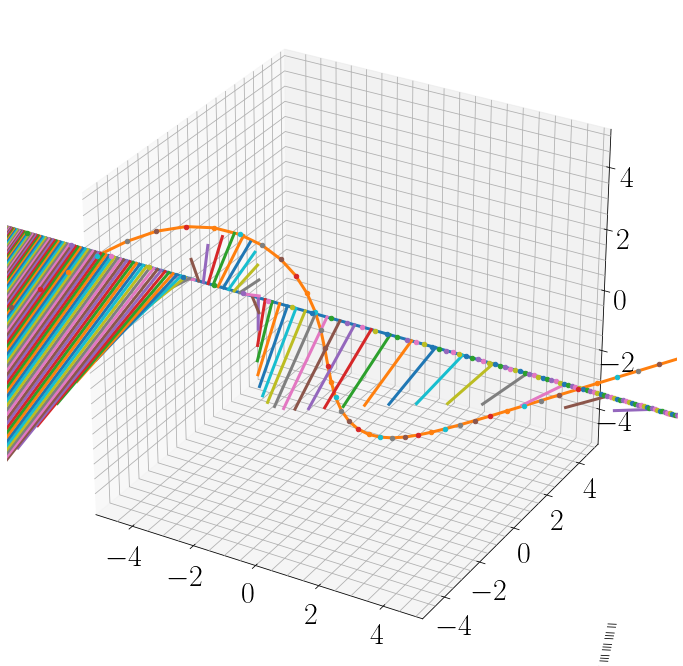

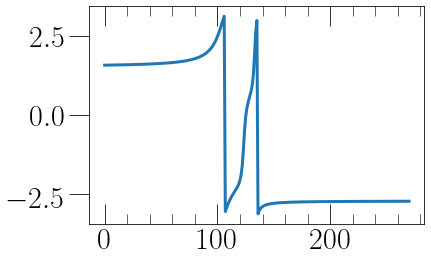

In [55]:
p = 'Data/TraceHeadOn_86_0_50/'
t, x, y, z = GetGeodesicTrajectory(p, 3000)
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
hx, hy, hz = horizon_at_time(t, "A")
plt.plot(hx, hy, hz)
lim = 5
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)
ax.set_zlim(-lim, lim)
ax.plot(x, y, z)

theta = []
for xx, yy, zz, hxx, hyy, hzz in zip(x, y, z, hx, hy, hz):
    ax.scatter(hxx, hyy, hzz)
    ax.scatter(xx, yy, zz)
    ax.plot([, [0.0, yy], [0.0, zz])
    theta.append(np.arctan2(zz, yy))
    
plt.show()

plt.figure()
plt.plot(theta)
plt.show()

2
2
2
3
3
1
2
1
2
2
2
2
2
1
2
2
3
2
2
2
2
2
1
1
2
2
3
1
2
1
3
2
1
1
2
3
2
1
1
2
2
2
2
2
2
3
2
1
3
2
2
3
2
1
1
2
2
1
1
2
2
1
2
3
2
4
2
2
3
1
1
2
2
2
2
2
1
1
2
1
2
2
2
2
2
1
1
2
2
1
2
2
2
2
2
1
2


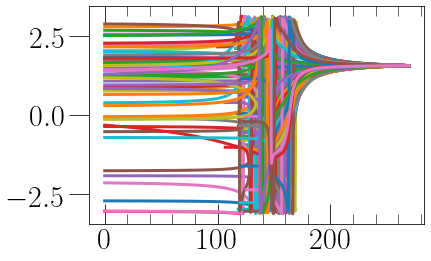

In [60]:
p = 'Data/TraceHeadOn_86_0_50/'

plt.figure()
Indices = GetGeodesicIndices(p)
for n in Indices[::100]:
    t, x, y, z = GetGeodesicTrajectory(p, n)
    theta = np.arctan2(z, y)
    zero_crossings = np.where(np.diff(np.sign(theta)))[0]
    print(len(zero_crossings))
    plt.plot(t, theta)
plt.show()
    

## Isotropic sphere distribution

No handles with labels found to put in legend.


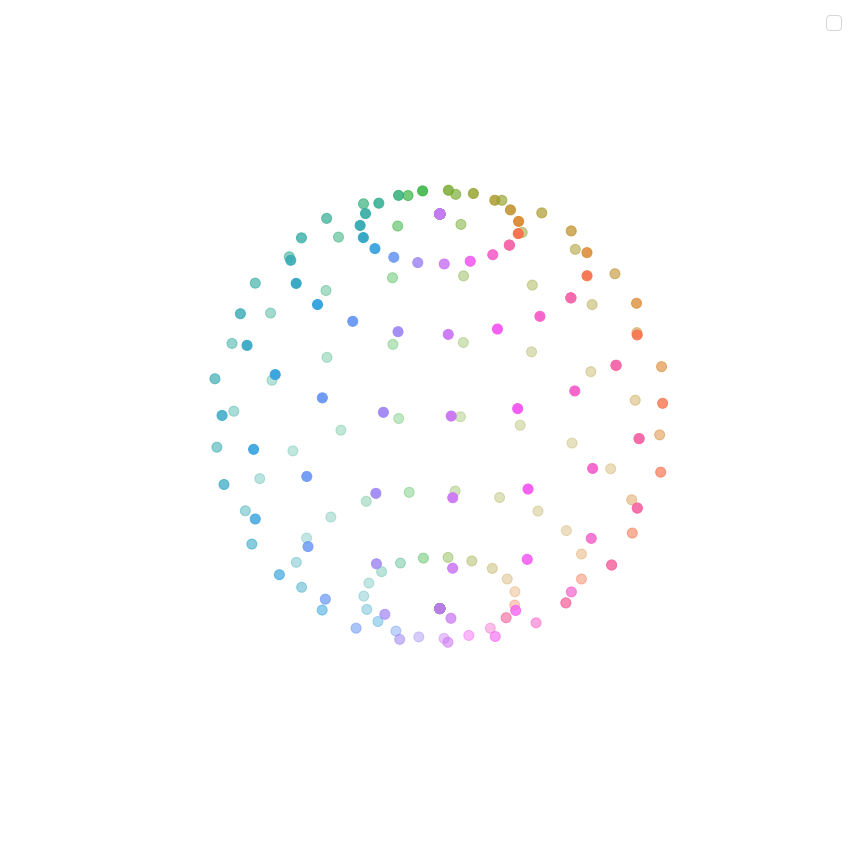

In [56]:
def SpherePlot():
    
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(111, projection='3d')
    
    ## Sphere radius
    R = 100
    
    ## Plot mesh sphere
    u, v = np.mgrid[0:2*np.pi:100j, 0:np.pi:100j]
    x = R*np.cos(u)*np.sin(v)
    y = R*np.sin(u)*np.sin(v)
    z = R*np.cos(v)
    #ax.plot_wireframe(x, y, z, color="blue", linewidth=0.1)
    
    
    ## Camera coordinates
    theta_points = 10
    phi_points = 20
    
    cs = sns.color_palette('husl', n_colors=phi_points)
    for u, i in zip(np.linspace(0, 2*pi, phi_points), range(phi_points)):
        x = []
        y = []
        z = []
        for v in np.linspace(0, pi, theta_points):
            x.append(R*np.cos(u)*np.sin(v))
            y.append(R*np.sin(u)*np.sin(v))
            z.append(R*np.cos(v))
            #print(int(R*np.cos(u)*np.sin(v)), int(R*np.sin(u)*np.sin(v)), int(R*np.cos(v)))
        ax.scatter(x, y, z, s=100, color=cs[i])
            
            
        
    #u, v = np.mgrid[0:2*np.pi:points, 0:np.pi:points]
    #x = R*np.cos(u)*np.sin(v)
    #y = R*np.sin(u)*np.sin(v)
    #z = R*np.cos(v)
    
    #ax.plot_wireframe(x, y, z, color="b", linewidth=0.1)
    
    
    ax.set_xlabel('Camera X',labelpad=20)
    ax.set_ylabel('Camera Y', labelpad=20)
    ax.set_zlabel('Camera Z', labelpad=20)
    ax.set_axis_off()
    lim = 100
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    
    plt.legend()
    plt.tight_layout()
    plt.savefig('Sphere.pdf')
    plt.show()

SpherePlot()